Muitas pessoas que estudam análise dados sabem aplicar o famoso PCA para reduzir a dimensionalidade de uma matriz, mas mais importante do que escrever as poucas linhas da função que faz isso em Python ou R é entender o que está acontecendo por dentro do método, ou seja, porque e como ele funciona.

Suponha que temos a seguinte matriz que eu mesmo criei, onde as colunas são atributos e as linhas são observações. Note que ela é bem simples, pois queremos preservar o máximo da intuição geométrica possível.


In [1]:
import pandas as pd 

data = {'Atributo_1':[1, 3, 3, 4, 5, 6, 6, 8], 'Atributo_2':[1, 1, 1, 1.7, 2, 1, 1.5, 2],
        'Atributo_3':[10, 20, 30, 10, 30, 40, 30, 50]} 
  
df = pd.DataFrame(data) 
df

,Atributo_1,Atributo_2,Atributo_3
0,1,1.0,10
1,3,1.0,20
2,3,1.0,30
3,4,1.7,10
4,5,2.0,30
5,6,1.0,40
6,6,1.5,30
7,8,2.0,50


In [25]:
import plotly.express as px
fig = px.scatter_3d(df, x='Atributo_1', y='Atributo_2', z='Atributo_3')
fig.show()

 A pergunta que queremos responder é: Em vez de usarmos três dimensões como temos na figura acima, poderíamos usar apenas duas sem prejudicar a qualidade dos dados? Vamos pensar em como podemos fazer isso. Para termos uma nova figura, mas com duas dimensões, precisamos criar um plano. Porém, queremos um plano muito específico, um que tente preservar todas as informações que tinhamos anteriormente. Então como encontrar os dois vetores que serão a base desse plano? Vamos tentar criar alguma intuição sobre isso.

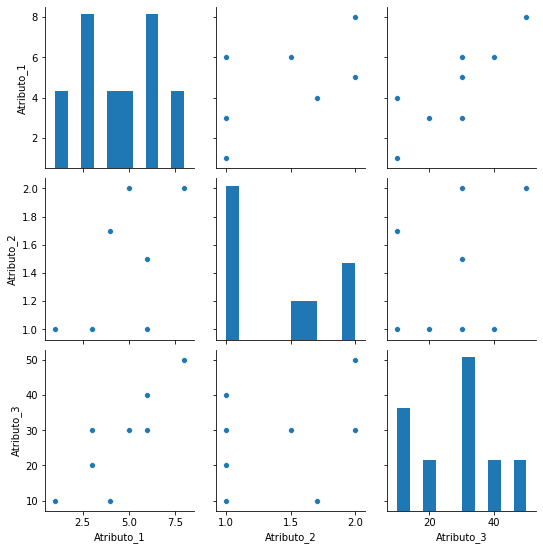

In [3]:
import seaborn as sns
sns.pairplot(df)

Plotando os eixos da nossa figura inicial, mas agora dois a dois, fingindo que não há um terceiro eixo, vemos que alguns deles parecem estar correlacionados como é o caso da figura no canto superior direito e inferior esquerdo. Isso significa que existe uma reta que pode capturar boa parte da variação dos dados desse gráfico. Ou seja, teremos uma reta que contém uma grande parcela da informação dos dois eixos, ela é o que chamamos de Componente Principal e será um dos vetores da base do nosso plano.

Após termos nosso plano, precisamos saber como representar os pontos que estavam no R³ no R². Para isso fazemos a projeção ortogonal dos pontos no plano. Isso pode ser mais facilmente compreendido de forma visual. Suponha que esse seja o melhor plano que captura a variação dos nossos dados. Nosso próximo passo é projetar nele os pontos que está no R³.

In [7]:
import numpy as np
import plotly.graph_objs as go
fig = px.scatter_3d(df, x='Atributo_1', y='Atributo_2', z='Atributo_3')
x = np.linspace(1,8,8)
y = np.linspace(1,5,2)
X,Y = np.meshgrid(x,y)
Z = (2*X + 3*Y + 15) 
fig.add_trace(go.Surface(x=x, y=y, z=Z, showscale=False, colorscale='Blues'))
fig.show()

Isso pode ser visto na imagem abaixo também, onde o ponto x seria uma das nossas bolinhas azuis.

![](my_icons/projecao.png)

Tendo uma visão geral agora vamos discutir como realmente calcular os vetores da base desse plano e sua projeção. Em primeiro lugar veja que nós devemos realizar uma etapa de pré-processamento para que os dados sejam igualmente tratados. Caso contrário, atributos com valores absoutos muito grandes podem receber maior importância, o que não deveria acontecer. Portanto a primeira etapa consiste em subtrairmos de cada atributo sua média. Com os vetores resultados dividimos cada um pelo seu desvio-padrão.

In [8]:
#Pre-Processamento
x = df.values
Media = np.mean(x, axis=0)
matriz_media = [Media,]*x.shape[0]
M = x - matriz_media
desvio_padrao = np.std(M, axis = 0)
scaled_x = (M/desvio_padrao)
scaled_x

array([[-1.69774938, -0.93632918, -1.34715063],
       [-0.72760688, -0.93632918, -0.57735027],
       [-0.72760688, -0.93632918,  0.19245009],
       [-0.24253563,  0.70224688, -1.34715063],
       [ 0.24253563,  1.40449377,  0.19245009],
       [ 0.72760688, -0.93632918,  0.96225045],
       [ 0.72760688,  0.23408229,  0.19245009],
       [ 1.69774938,  1.40449377,  1.73205081]])

In [9]:
scaled_data = {'Atributo_1':scaled_x[:,0], 'Atributo_2':scaled_x[:,1],
        'Atributo_3':scaled_x[:,2]} 
  
scaled_df = pd.DataFrame(scaled_data) 
fig = px.scatter_3d(scaled_df, x='Atributo_1', y='Atributo_2', z='Atributo_3')
fig.show()

Agora temos duas grande diferenças em relação ao gráfico original. Primeiro, os dados estão centrados na origem, pois agora a média deles é zero. Segundo, todos os eixos tem a mesma importância. Nenhum neles tem números absurdamente maiores que dos outros. Apesar da diferença note como a estrutura dos dados é exatamente a mesma. Só os valores do eixo estão diferentes.

![](my_icons/graf1.png)

Agora vamos pensar em como descobrir qual o melhor plano para projetarmos nossos dados. A equação que mostra onde queremos chegar pode ser dada por $Y = PX$. Vamos discutir cada uma dessas matrizes. $P$ é uma matriz de projeção, ou seja ela projeta algo em algum lugar. Ela vai projetar pontos da matriz $X$ em um novo espaço vetorial, que no nosso caso é um plano. De outro modo podemos dizer que ela é uma transformação linear $T$ onde $T: R³ \rightarrow R²$. $Y$ por sua vez é a matriz resultante com as novas coordenadas. Um detalhe é que ao fazermos a multiplicação $PX$ estamos projetando as linhas de $X$ no novo espaço vetorial. Portanto, precisamos transpor nossa matriz original para que suas linhas sejam os atributos, pois são eles quem nos queremos projetar. Dessa forma temos que a primeira coluna de $Y$ é $Px_{1}$ onde $x_{1}$ é a primeira coluna de $X$ e assim por diante. 

![](my_icons/Y.png)

Nosso objetivo agora é descobrir quem é $P$, mas vamos analisar $Y$ para descobrir alguma coisa a respeito. Queremos que $Y$ não tenha informação redundante, ou seja, que ele não tenho variáveis correlacionadas, o que significa que buscamos um covariância igual 0 entre as variáveis de $Y$. Por outro lado queremos maximizar a variância, pois isso significa que estaremos conseguindo captar a maior quantidade possível de informações. Portanto nossa matriz de convariância de $Y$ deve ser uma matriz diagonal. Sendo $C_{y}$ a covariância de $Y$ então temos que:

$C_{y} = \frac{1}{n-1}YY^T = \frac{1}{n-1}(PX)(PX)^T = \frac{1}{n-1}PXX^TP^T = \frac{1}{n-1}PSP^T$

Onde $S=XX^T$ e $n$ é o número de observações da matriz $Y$. Veja que $S$ é uma matriz simétrica, portanto ela admite uma decomposição espectral tal que $S = Q\Lambda Q^T$. Portanto temos que $C_{y} = \frac{1}{n-1}PQ\Lambda Q^TP^T = \frac{1}{n-1}(PQ)\Lambda (PQ)^T $. Como dito anteriormente, queremos que $C_{y}$ seja uma matriz diagonal então $PQ$ tem que ser a matriz identidade. Para isso acontecer pode simplesmente tomar $P=Q^T$, dessa forma finalmente chegamos em $C_{y} = \frac{1}{n-1}\Lambda$, uma matriz diagonal onde $\Lambda$ contém a importância de cada componente.

Por fim, perceba que podemos aplicar SVD em $X$ então $X=U\Sigma V^T$, logo $S=XX^T = U\Sigma V^T V\Sigma^T U^T = U\Sigma \Sigma^T U^T$ onde podemos perceber que $U=E$, portanto $P=U$.

Vamos fazer enfim terminar a matriz do início essa discussão. Lembrando que ela já foi normalizada e processada para ter média igual a zero, precisamos agora transpô-la para que seus atributos estejam nas linhas e então seguir com o que foi explicado.

In [13]:
scaled_x_t = scaled_x.T
S = scaled_x_t @ scaled_x_t.T
u, s, vh = np.linalg.svd(S)
Y = u.T @ scaled_x_t
Y.T

array([[ 2.34592819, -0.17881354,  0.19628223],
       [ 1.26617707,  0.35971583, -0.08281041],
       [ 0.81998399,  0.79804911,  0.36593033],
       [ 0.59695461, -1.36484191, -0.38424052],
       [-0.95448338, -1.01078694,  0.36842169],
       [-0.57654615,  1.38667652, -0.27707901],
       [-0.70080773, -0.00617283, -0.36065738],
       [-2.79720661,  0.01617376,  0.17415309]])

Para confirmar os resultados podemos usar as funções prontas. Nosso resultado está correto apesar do sinal diferente, pois as componentes são vetores que apontam direções. Mudar o sinal não muda a variância contida no vetor (para mais informações: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers). 

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_decomp = pca.fit(scaled_x)
pca_x = pca_decomp.transform(scaled_x)
pca_x

array([[-2.34592819, -0.17881354, -0.19628223],
       [-1.26617707,  0.35971583,  0.08281041],
       [-0.81998399,  0.79804911, -0.36593033],
       [-0.59695461, -1.36484191,  0.38424052],
       [ 0.95448338, -1.01078694, -0.36842169],
       [ 0.57654615,  1.38667652,  0.27707901],
       [ 0.70080773, -0.00617283,  0.36065738],
       [ 2.79720661,  0.01617376, -0.17415309]])

Podemos também calcular o quão importante cada componenete é. Isso é bem simples, basta dividir a variância da componente pela variância total.

In [18]:
variancia = np.var(Y, axis = 1)
sum_var = np.sum(variancia)
print("Variância explicada pela primeira componente: ", variancia[0]/desvio_padrao_quadrado)
print("Variância explicada pela segunda componente: ", variancia[1]/desvio_padrao_quadrado)
print("Variância explicada pela terceira componente: ", variancia[2]/desvio_padrao_quadrado)

Variância explicada pela primeira componente:  0.7372605113484414
Variância explicada pela segunda componente:  0.23357947093949818
Variância explicada pela terceira componente:  0.029160017712060476


Apenas confirmando:

In [19]:
pca.explained_variance_ratio_

array([0.73726051, 0.23357947, 0.02916002])

Por último, vamos mostrar no gráfico o plano gerado pelo PCA. Sabemos que as linhas de $U$ são os vetores que capturam a maior variância dos dados, portanto como queremos um plano pegaremos as duas primerias linhas como base.


In [24]:
u

array([[-0.65305667,  0.10327976, -0.75023348],
       [-0.48739668, -0.81553889,  0.31199487],
       [-0.57962182,  0.56941164,  0.58293132]])